# Simulating Motion Artifacts

In [42]:
import tensorflow as tf

import pathlib
import imageio
import numpy as np

import random

from PIL import Image, ImageDraw, ImageFont



print(tf.__version__)

tf.enable_eager_execution()

1.14.0


In [43]:
data_root = "./data_initial_labels//"

# load an array of image paths
def load_image_paths(path):
    
    data_root = pathlib.Path(path)
    
    paths = []
    
    for child in data_root.iterdir():
        if (child.is_dir()):
            print(child)
            
            subdir_paths = list(child.glob('**/*'))
            subdir_paths = [str(path) for path in subdir_paths]
        
            paths.append(subdir_paths)
    
    return paths

paths = load_image_paths(data_root)
print(paths[2][0])

data_initial_labels/0
data_initial_labels/1
data_initial_labels/2
data_initial_labels/2/2d51c7b3-a0d6-4450-a747-f488f0de44d7.png


data_initial_labels/0/b4c46562-5a7c-4e52-9b86-1545c69a3550.png
(512, 512)


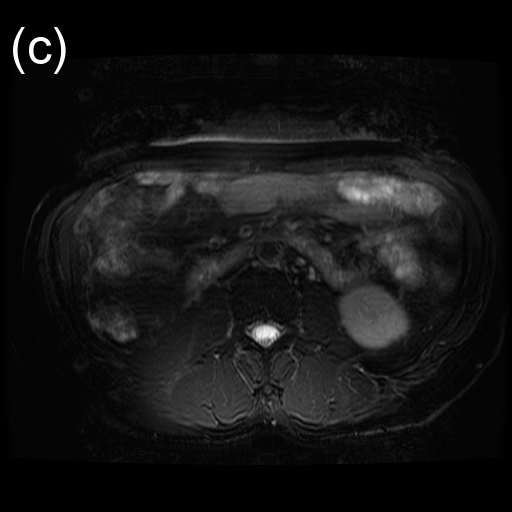

In [80]:
# 2 9 best result

image_path = paths[0][19]

print(image_path)

im = imageio.imread(image_path)
print(im.shape)

display1 = Image.fromarray(im)

display1_draw = ImageDraw.Draw(display1)

display1_draw.text((10,10), "(c)", fill="white", font=ImageFont.truetype("./fonts/arial.ttf", 50))

display(display1)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


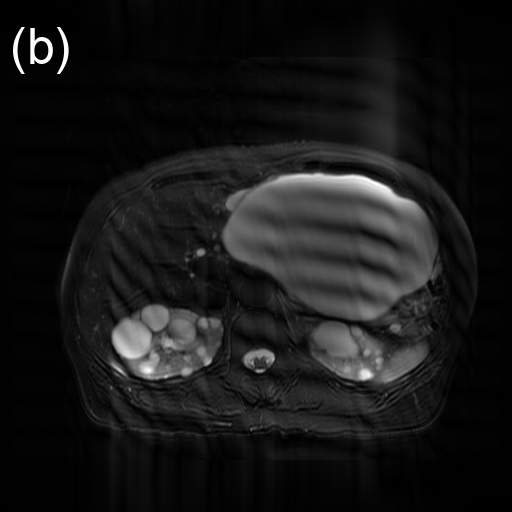

In [53]:
lf = 1200

def row_artifact(row, linear_factor):
        
    alpha = random.uniform(-1 * linear_factor, linear_factor)
    
    counter = 0
    for t in np.linspace(0, 0.002, num=row.size):
        row[counter] = row[counter] * np.exp(alpha * t )
        
        counter = counter + 1
        
    return row

def add_artifact(img, start=0, end=511, max_lf=500, seed=777): 
    
    random.seed(seed)
    
    for index in range(start, end):
        img[index] = row_artifact(img[index], max_lf)
        
    return img

def reconstruct(img):
    
    img = np.absolute(np.fft.ifft2(img))

    img = np.around(img * 255.0 / np.max(img))
    
    return img


im_transformed = np.fft.fft2(im)

im_transformed_artifacted = add_artifact(im_transformed, start=10, end=20, max_lf=lf)

image = reconstruct(im_transformed_artifacted)
image = np.uint8(image)


print(image)

display2 = Image.fromarray(image)

display2_draw = ImageDraw.Draw(display2)

display2_draw.text((10,10), "(b)", fill="white", font=ImageFont.truetype("./fonts/arial.ttf", 50))

display(display2)

# Playing with Data Augmentations

In [95]:


def rotate(image):
    
    return tf.image.rot90(image, tf.random_uniform(shape=[], minval=0, maxval=4, 
                                               dtype=tf.int32))

def flip(image):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    return image

def crop(image, range_start=0.8, range_end=1):
    
    image = tf.image.central_crop(image, central_fraction=random.uniform(range_start, range_end))
    image = tf.image.resize_images(image,tf.constant([512, 512]))
    return image

def translate(image,  x_max=75, y_max=75):
    
    return tf.contrib.image.translate(image, translations=[random.uniform(0, x_max), random.uniform(0, y_max)])

def augment_image(image):
                       
    # use image[:,:,None] for actual
        
    # dont forget about batch sizing when adjusting the image
    image = rotate(image)
    image = flip(image)
    image = translate(image)
    image = crop(image)
    
    return image


data/2/c98a368c-5493-47dc-8d7e-f3b76a857cc2.png
(512, 512)


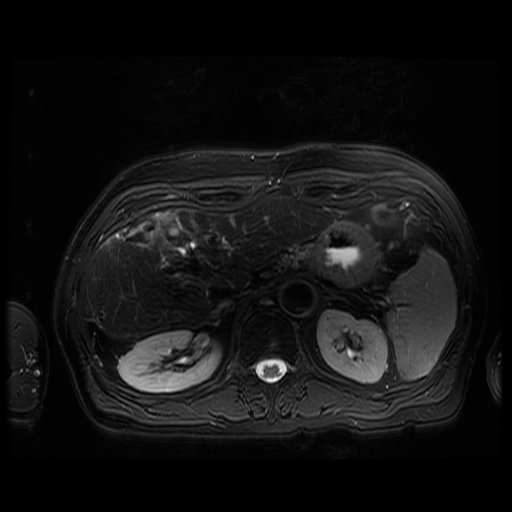

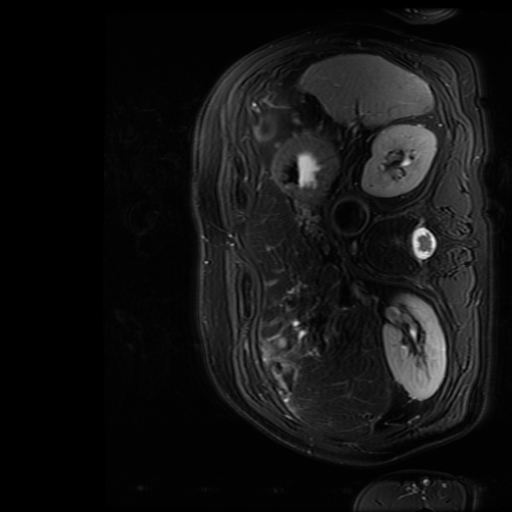

In [98]:
image_path = paths[2][1]

print(image_path)

im = imageio.imread(image_path)
print(im.shape)

display1 = Image.fromarray(im)
display(display1)

im_tensor = tf.convert_to_tensor(im)
im_tensor = tf.reshape(im_tensor, shape=[512,512,1])


im_tensor = augment_image(im_tensor)
im_augmented = tf.reshape(im_tensor, shape=[512,512])
im_augmented = im_augmented.numpy()


im_augmented = np.uint8(im_augmented)


display2 = Image.fromarray(im_augmented)
display(display2)


##### 